# Paradigm 
Subjects are required to perform speed-fixed movement before and after TMS while EEG and EMG are recorded.

Variables:
- Fatigue: After one session, subjects start to suffer from tiredness. 
- auditory stimulus: its effect is well known is ERP analysis, thus it is better to perform experiment in a silent situation

**Solution**:four sections in total, two in succesion without TMS. After one day of relexation, another two sessions are executed with TMS in between.
## devices
- Fourier M2 rehabilitation device
- NeuroElectric EEG recording device (32 channels)
- labmade EMG recording device (10 channels)
Improvement: elastic sleeve-like equipment with electrodes sticking inside. (the goal is to make it easy and less painful for stroke patients to put on)   

# Preprocessing
converting to python-based platform
## EEG
1. format transformation .easy-> .set
2. bad channels detection (filters are integrated), this merged mainly from pyprep - autoReject method is another possibility.
3. continuous ICA - testing (Referring to FRP, studies with varied-length epochs did all the preprocessing before epoching)


## EMG
1. reading in .txt file, and cached in mne object. 
2. detect movement and segmentation
 

# Data storage
mne is the base

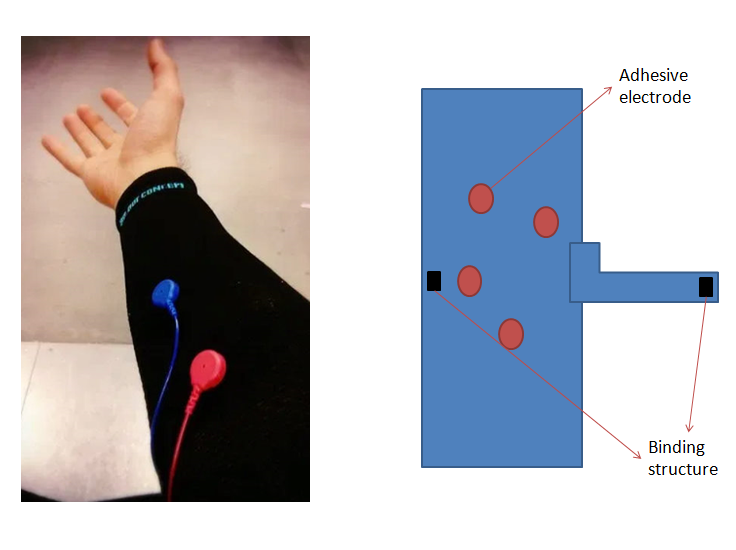

In [1]:
from IPython.display import Image
Image("emg_improvement.png")

In [308]:
############### Parameters ###################
#Data
num_emgs = 10
sfreq = 1000
sfreq_final =500
#############################################

# read set data that only have been through format changing
import mne
import pyprep
import pandas as pd
from matplotlib import pyplot as plt
eeg_dirName = r'D:\Data\RuiJinFirstStroke11Jan\EEG'
emg_dirName = r'D:\Data\RuiJinFirstStroke11Jan\EMG'
eeg_fName = eeg_dirName+'\subj1_healthy_session1.set'
emg_fName = emg_dirName+'\subj1_healthy_session1.txt'

raw_eeg = mne.io.read_raw_eeglab(eeg_fName)
raw_eeg.set_montage('standard_1020')
eeg_onset=mne.events_from_annotations(raw_eeg)[0][0,0]
raw_eeg.crop(tmin = eeg_onset/sfreq_final)

# read EMG
ch_types = ['emg']*num_emgs
ch_names = []
for i in range(num_emgs):
    ch_names.append('emg'+str(i+1))
emg_data = pd.read_csv(emg_fName, header = None, skiprows=3,
                       sep = ' ',engine = 'python')
emg_data = emg_data.drop([4,11,12,13,14,15,16,17,18],axis=1)

# data snapping - will be mutual later
eeg_len = raw_eeg._data.shape[1]
emg_data = emg_data.iloc[0:eeg_len*2]

emg_data = (emg_data/1e7).T
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw_emg = mne.io.RawArray(emg_data, info)
raw_emg.resample(sfreq=sfreq_final)

raw_hybrid = raw_eeg.add_channels([raw_emg]).copy()

# for application purpose
raw_hybrid.crop(tmin = 29500/2/sfreq_final, tmax = 83000/2/sfreq_final)

<ipython-input-308-ba97ded5f3b9>:18: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_eeg = mne.io.read_raw_eeglab(eeg_fName)


DigMontage is a superset of info. 62 in DigMontage will be ignored. The ignored channels are: {'F6', 'PO2', 'C1', 'AF9', 'PO8', 'M1', 'AF8', 'A2', 'T10', 'P1', 'A1', 'AF7', 'T5', 'FT10', 'POz', 'F2', 'O9', 'P9', 'FCz', 'P6', 'O10', 'TP7', 'CPz', 'T6', 'AFz', 'C6', 'F10', 'PO9', 'F1', 'TP8', 'T4', 'FC3', 'T9', 'M2', 'Iz', 'TP10', 'PO7', 'PO5', 'AF1', 'Fpz', 'FT7', 'CP4', 'PO6', 'P2', 'FT9', 'C2', 'AF10', 'P5', 'PO1', 'TP9', 'T3', 'FC4', 'AF5', 'PO10', 'AF6', 'FT8', 'P10', 'F5', 'AF2', 'CP3', 'C5', 'F9'}
Used Annotations descriptions: ['1']
Creating RawArray with float64 data, n_channels=10, n_times=303726
    Range : 0 ... 303725 =      0.000 ...   303.725 secs
Ready.


<RawEEGLAB  |  subj1_healthy_session1.set, n_channels x n_times : 42 x 26751 (53.5 sec), ~8.7 MB, data loaded>

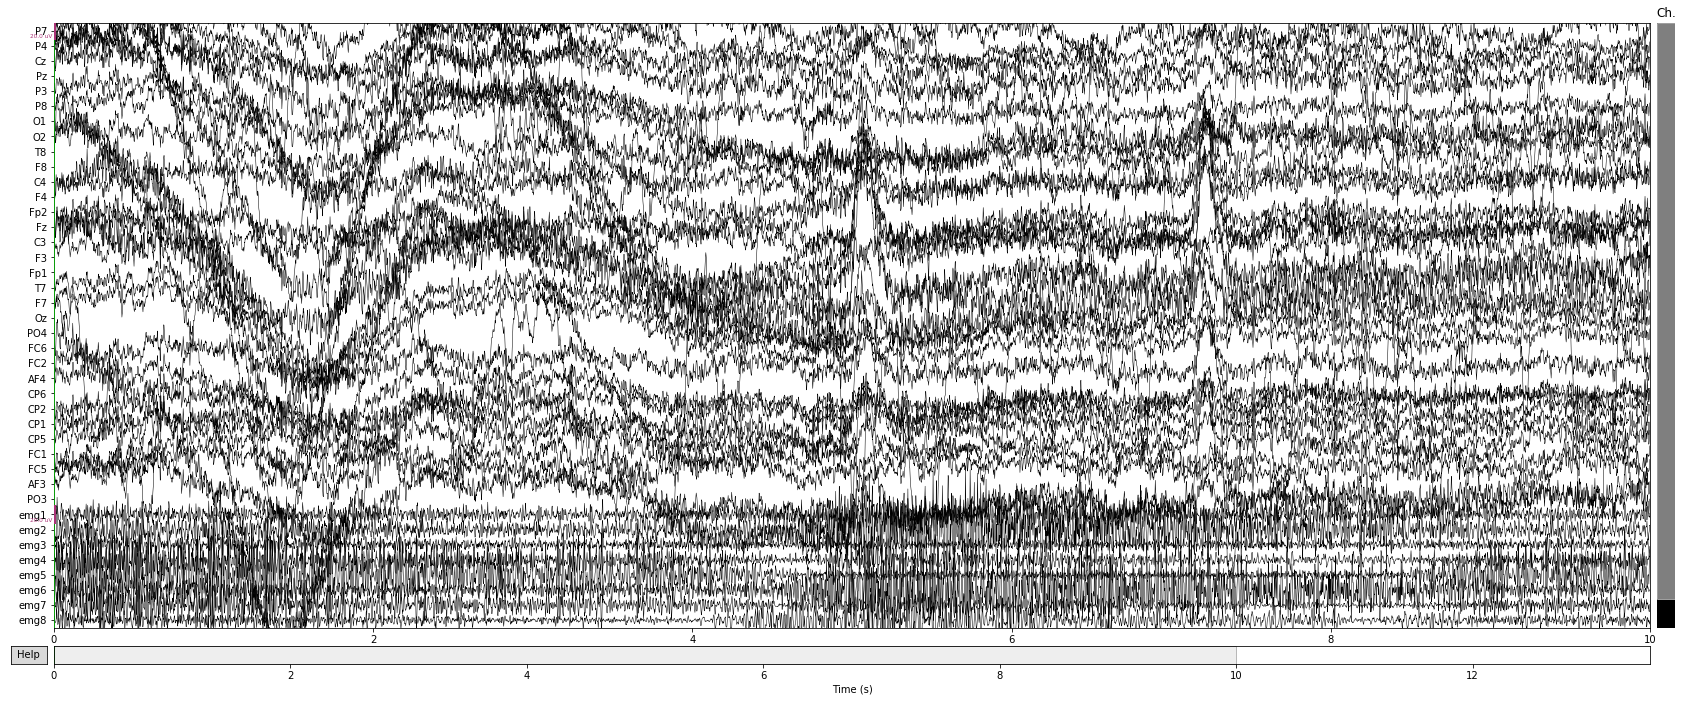

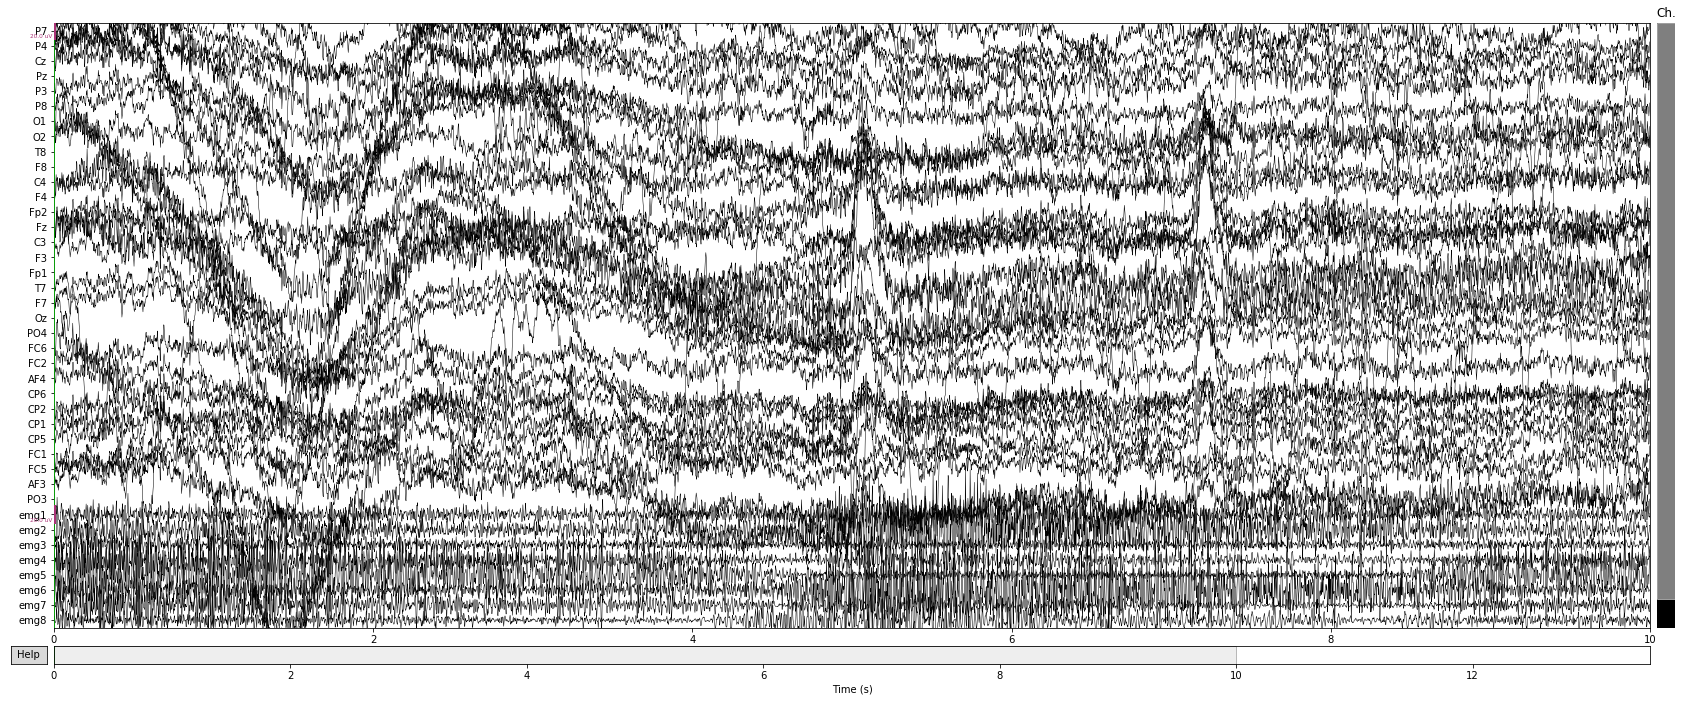

In [243]:
%matplotlib qt
raw_hybrid.plot(scalings=1e-5,n_channels=40)

In [309]:
# Connectivity for 2-8Hz band and calculate MST
#Important - link to the channel name
from mne.connectivity import spectral_connectivity
import networkx as nx

raw_hybrid_con = raw_hybrid.copy()
#epochs_hybrid_con = mne.Epochs(raw_hybrid_con,)
data_hybrid = raw_hybrid_con._data

data_hybrid_expded = np.expand_dims(data_hybrid,axis=0)
#data_hybrid_expded.shape
# epochs_hybrid.load_data()
fmin = 1
fmax = 30
tmin=0
con, freqs, times,n_epochs,n_tapers = spectral_connectivity(
    data_hybrid_expded, method='coh', mode='multitaper', sfreq=sfreq_final, fmin=fmin, fmax=fmax,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)


cntvt_graph = nx.Graph(con[:, :, 0])
mst_cntvt = nx.maximum_spanning_tree(cntvt_graph)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 861 connections
    using t=0.000s..53.500s for estimation (26751 points)
    frequencies: 1.0Hz..30.0Hz (1552 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    assembling connectivity matrix (filling the upper triangular region of the matrix)
[Connectivity computation done]


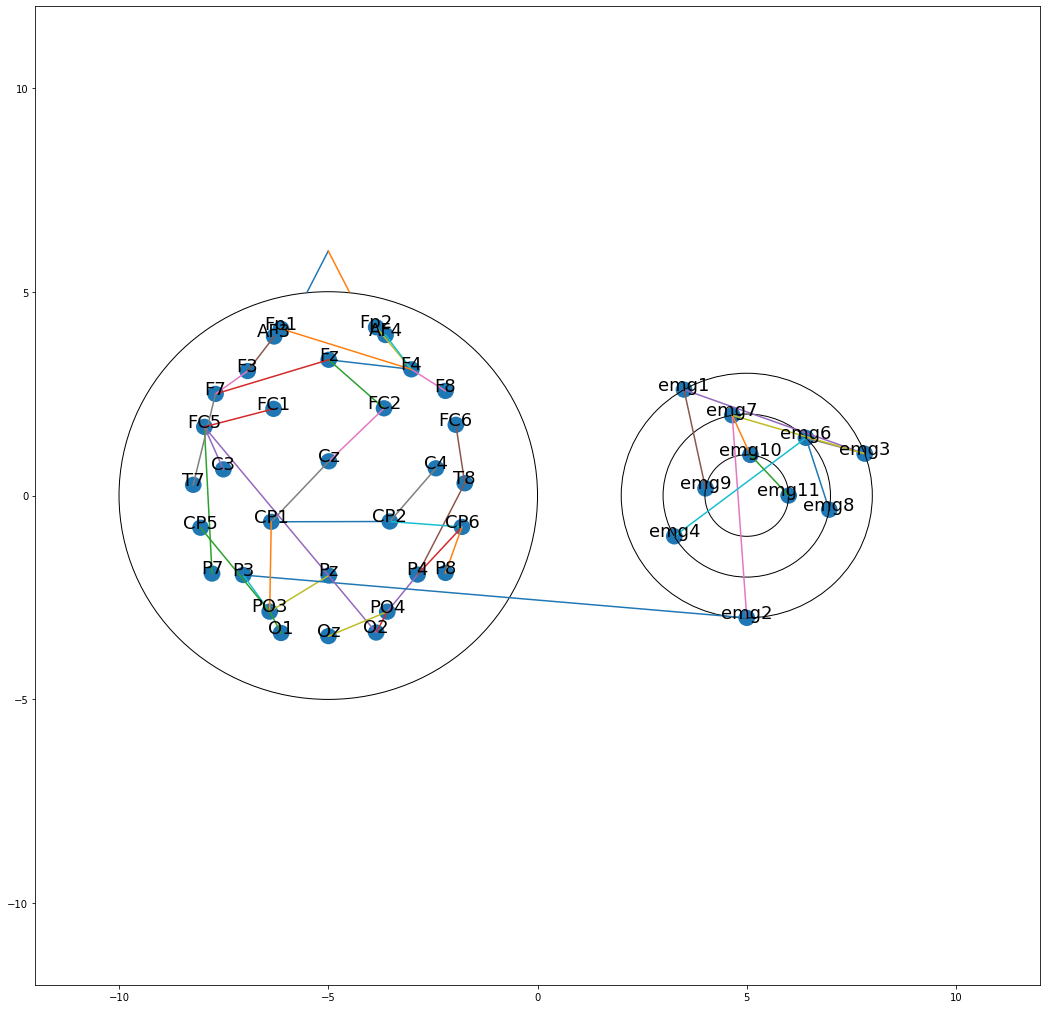

In [310]:
# visualization
# Define EMGChannel class
# the unit of phi is degree

from itertools import count

class EEGChannel:
    '''innitilized by info chs'''
    _ids = count(0)
    
    def __init__(self, x, y,name="None"):
        self.id = next(self._ids)
        self.x = x
        self.y = y
        self.name = name
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax 

    
class EMGChannel:
    '''with polar coordinates as inputs'''
    
    _ids = count(0)
    
    def __init__(self, rho, phi,name="None"):
        self.id = next(self._ids)
        self.rho = rho
        self.phi = phi
        self.name = name
        self.x = rho * np.cos(phi/180*np.pi)
        self.y = rho * np.sin(phi/180*np.pi)
        
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax        
    
    def cartesianC(self):
        return(self.x, self.y)
    
    def polarC(self):
        return(self.rho,self.phi)

#polar object definition - with transformation method

EMGs=[EMGChannel(3,120,'emg1'),EMGChannel(3,-90,'emg2'),EMGChannel(3, 20,'emg3'),EMGChannel(2,-150,'emg4'),
      EMGChannel(2, 45,'emg6'),EMGChannel(2,100,'emg7'),EMGChannel(2, -10,'emg8'),
      EMGChannel(1,170,'emg9'),EMGChannel(1,85,'emg10'),EMGChannel(1, 0,'emg11')]

EEGs = [EEGChannel(x=ch['loc'][0]*40,y=ch['loc'][1]*40,name=ch['ch_name']) for ch in raw_hybrid.info['chs']] 
# 2D Visualization
# head's center is at (-6,0) while that of arm is at (6,0)

%matplotlib inline
import matplotlib.pyplot as plt

# EMG Topograph_basis
def plotTopoEMG(EMGs,ax,center=[5,0]):
    for i in range(3):
        circle = plt.Circle((center[0],center[1]), i+1,fill = False)
        ax.add_artist(circle)
    for EMG in EMGs:
        ax = EMG.plot(ax,center)
    return ax

def plotTopoEEG(EEGs,ax,center=[-5,0]):
    circle = plt.Circle((center[0],center[1]),5,fill = False)
    ax.plot([-5.5,-5],[5,6])
    ax.plot([-5,-4.5],[6,5])
    ax.add_artist(circle)
    for EEG in EEGs:
        ax = EEG.plot(ax,center)
    return ax

def con_MST_plot(mst_cntvt,ax,center_EEG=[-5,0],center_EMG=[5,0]):
    for (i,j) in mst_cntvt.edges:
        if i>31:
            if j>31:
                ax.plot([EMGs[i-32].x+center_EMG[0], EMGs[j-32].x+center_EMG[0]],
                        [EMGs[i-32].y+center_EMG[1], EMGs[j-32].y+center_EMG[1]])
#             print(i)
#             print(EMGs[i-32].x,EMGs[j-32].x)
            else:
                ax.plot([EMGs[i-32].x+center_EMG[0], EEGs[j].x+center_EEG[0]],
                        [EMGs[i-32].y+center_EMG[1], EEGs[j].y+center_EEG[1]])
        else:
            if j>31:
                ax.plot([EEGs[i].x+center_EEG[0], EMGs[j-32].x+center_EMG[0]],
                        [EEGs[i].y+center_EEG[1], EMGs[j-32].y+center_EMG[1]])
            else:
                ax.plot([EEGs[i].x+center_EEG[0], EEGs[j].x+center_EEG[0]],
                        [EEGs[i].y+center_EEG[1], EEGs[j].y+center_EEG[1]])
            


plt.figure(figsize=(18, 18), facecolor='w', edgecolor='k')
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
con_MST_plot(mst_cntvt,ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()


In [291]:
def con_MST_plot(mst_cntvt,ax):
    for (i,j) in mst_cntvt.edges:
        if i>31:
            if j>31:
                ax.plot([EMGs[i-32].x, EMGs[j-32].x],[EMGs[i-32].y, EMGs[j-32].y])
            else:
                ax.plot([EMGs[i-32].x, EEGs[j].x],[EMGs[i-32].y, EEGs[j].y])
        else:
            if j>31:
                ax.plot([EEGs[i].x, EMGs[j-32].x],[EEGs[i].y, EMGs[j-32].y])
            else:
                ax.plot([EEGs[i].x, EEGs[j].x],[EEGs[i].y, EEGs[j].y])
            

TypeError: con_MST_plot() missing 1 required positional argument: 'ax'

In [287]:
mst_cntvt.edges

EdgeView([(0, 29), (1, 24), (1, 20), (1, 8), (2, 22), (2, 26), (3, 31), (4, 31), (4, 33), (5, 24), (6, 31), (7, 20), (7, 29), (8, 21), (9, 11), (10, 25), (11, 12), (11, 23), (11, 13), (11, 16), (13, 22), (13, 18), (14, 29), (15, 30), (15, 18), (17, 18), (19, 20), (24, 25), (25, 26), (26, 31), (27, 31), (28, 29), (32, 34), (32, 39), (33, 37), (34, 36), (34, 37), (35, 36), (36, 38), (37, 40), (40, 41)])

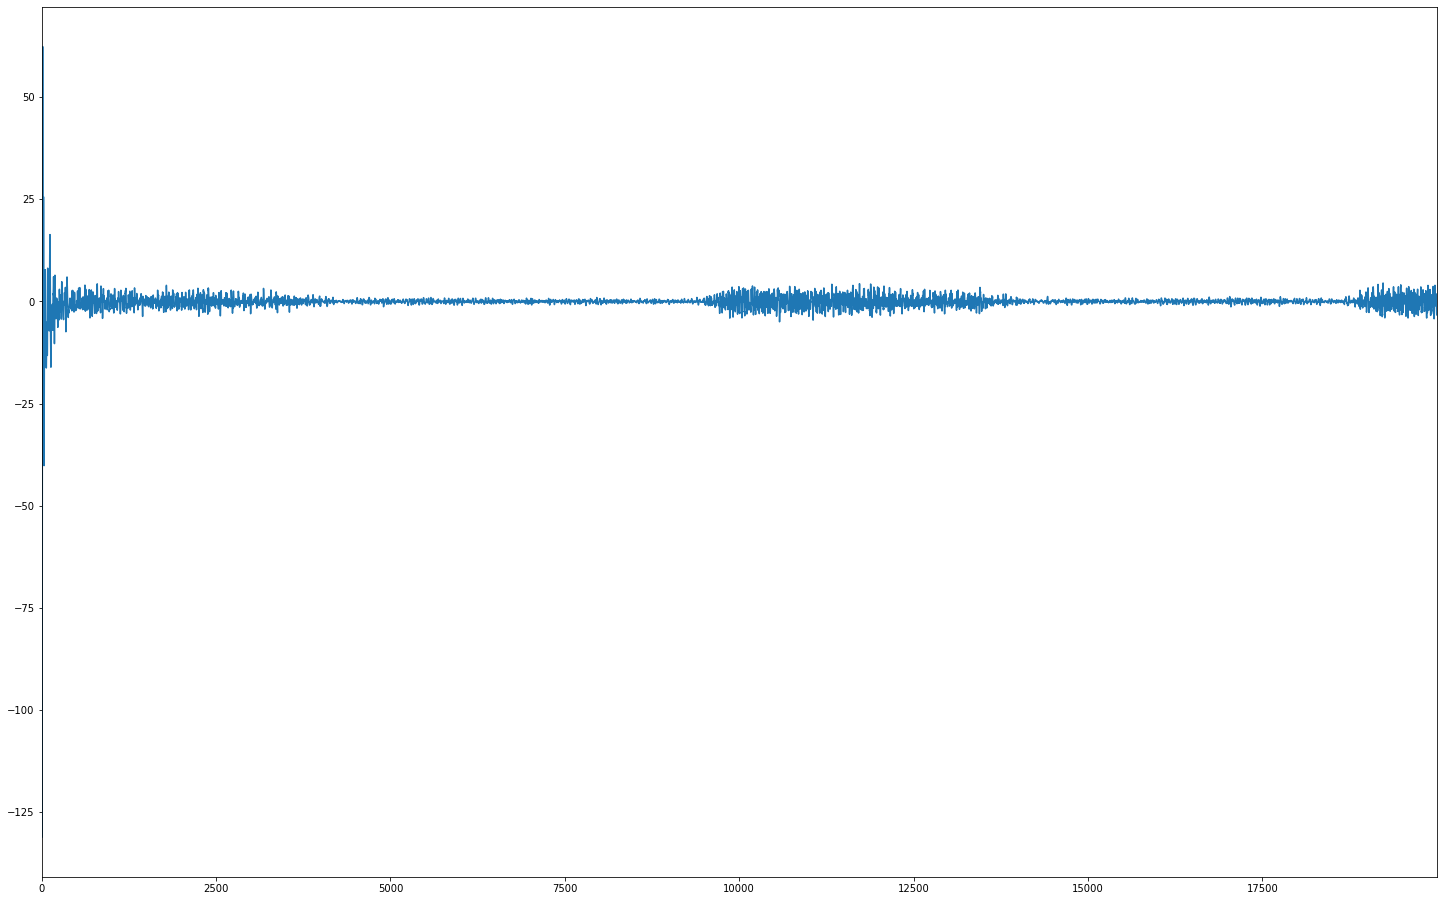

In [109]:
# find event using iteration

# First conclusion 9500-13000 samples

emg_data = emg_data.iloc[0:20000]
emg_sgnfc = emg_data[9]
emg_sgnfc_smooth = emg_sgnfc.rolling(window=100).mean()
# emg_sgnfc_smooth.plot(figsize=(25,16))
emg_sgnfc_smooth = emg_sgnfc.ewm(span = 1000).mean()
emg_sgnfc_smooth.plot(figsize=(25,16))
emg_sgnfc_smooth.describe()
# import statsmodels.api as sm
# import numpy as np
# lowess = sm.nonparametric.lowess
# x = np.arange(len(emg_sgnfc))
# z = lowess(emg_sgnfc, x)
# z.plot()

threshold = 0.5
emg_data['seg_ref' ]=emg_sgnfc_smooth
emg_data['next_seg_ref' ]=emg_data.seg_ref.shift(-1)
emg_data['next2_seg_ref' ]=emg_data.next_seg_ref.shift(-1)
emg_data['next3_seg_ref' ]=emg_data.next_seg_ref.shift(-10)
emg_data['next4_seg_ref' ]=emg_data.next_seg_ref.shift(-100)
emg_data['offsets'] = (
    ((np.abs(emg_data.seg_ref) >= threshold) & (np.abs(emg_data.next_seg_ref )<= threshold) &
     (np.abs(emg_data.next2_seg_ref )<= threshold)&
     (np.abs(emg_data.next3_seg_ref )<= threshold)&
     (np.abs(emg_data.next4_seg_ref )<= threshold)))
offsets_list = emg_data.index[emg_data['offsets'] == True].tolist()

In [110]:

offsets_list

[819,
 914,
 1055,
 1138,
 1147,
 1247,
 1383,
 1410,
 1457,
 1495,
 1510,
 1517,
 1534,
 1575,
 1602,
 1692,
 2168,
 2324,
 2497,
 2503,
 2577,
 2587,
 2628,
 2657,
 2687,
 2696,
 2702,
 2775,
 2848,
 2935,
 3009,
 3034,
 3039,
 3066,
 3128,
 3134,
 3208,
 3322,
 3372,
 3419,
 3457,
 3462,
 3484,
 3492,
 3553,
 3571,
 3598,
 3661,
 3676,
 3711,
 3736,
 3758,
 3784,
 3850,
 3907,
 3922,
 4004,
 4120,
 4189,
 4336,
 4449,
 4527,
 4565,
 4573,
 4622,
 4700,
 4717,
 4771,
 4976,
 5008,
 5027,
 5069,
 5183,
 5275,
 5342,
 5425,
 5501,
 5517,
 5560,
 5616,
 5688,
 5724,
 5778,
 5795,
 5854,
 5887,
 5916,
 5935,
 5964,
 5974,
 6005,
 6042,
 6110,
 6184,
 6199,
 6224,
 6295,
 6368,
 6410,
 6448,
 6478,
 6514,
 6576,
 6627,
 6752,
 6773,
 6788,
 6942,
 6952,
 6975,
 6997,
 7028,
 7037,
 7286,
 7354,
 7453,
 7505,
 7525,
 7561,
 7581,
 7647,
 7717,
 7805,
 7872,
 7979,
 8022,
 8066,
 8097,
 8244,
 8261,
 8325,
 8341,
 8449,
 8561,
 8581,
 8680,
 8757,
 8801,
 8857,
 8999,
 9175,
 9320,
 9732,
 

37.310526315789474